In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
 

In [38]:


def getFPICSUMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

Reproduce Figure 8 in 
"A Comparison of Numerical Algorithms for Fourier Extension of the First, Second, and Third Kinds"
John P. Boyd
Department of Atmospheric, Oceanic and Space Science, University of Michigan, 2455 Hayward Avenue,
Ann Arbor, Michigan 48109-2143
Received July 6, 2001; revised February 12, 2002"


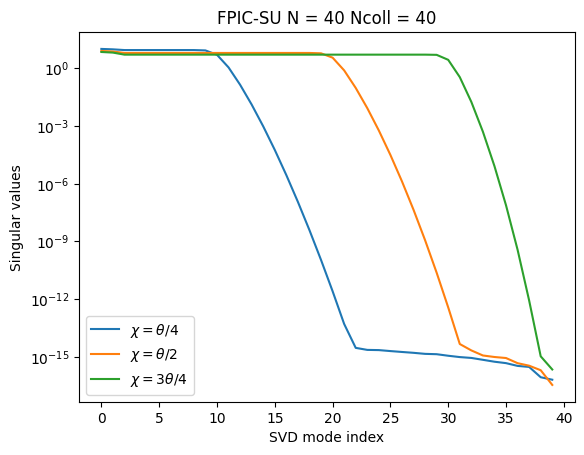

In [39]:

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index") 
plt.yscale("log") 

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for chi, label in zip(chis, labels): 
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label)
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [40]:
chi = theta/2 

M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

Compute pseudoinverse by inverting $S$ with cutoff

In [43]:
def invertM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T

#Test implementation of invert M
A = np.random.rand(10, 10)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertM(A, 0)), 0, atol=1e-13)


Finally compute the periodic extension of an even function ($f(x) = x^2$ in this example)

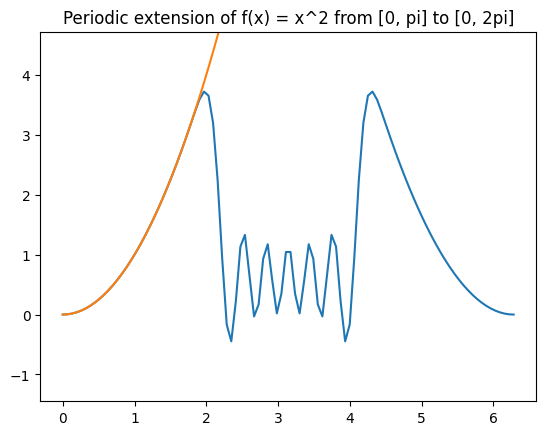

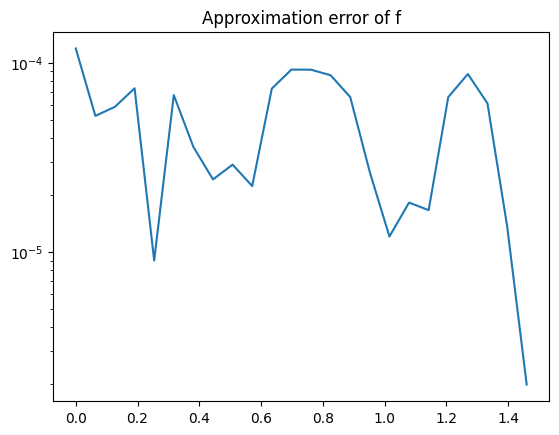

In [71]:
N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return x**2

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 100)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = x^2 from [0, pi] to [0, 2pi]")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

Improve this result by using iterative refinement

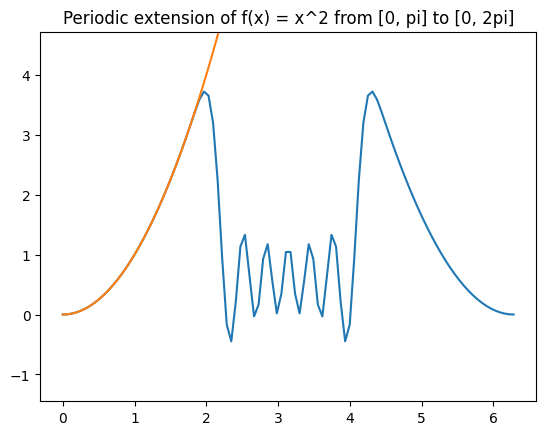

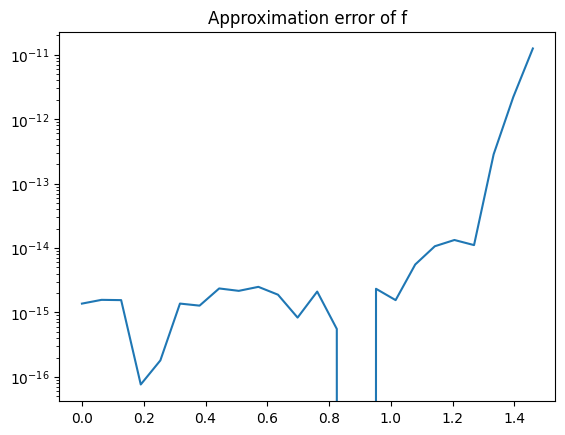

In [77]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a): 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        maxiter += 1
        if counter > maxiter:
            break
    return a

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return x**2

f     = func(x) 
Minv  = invertM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 3)

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 100)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = x^2 from [0, pi] to [0, 2pi]")
plt.plot(xext, frec, label="Extension") 
plt.plot(xext, func(xext), label="Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

In [21]:
s

array([7.91230643e+00, 7.41426922e+00, 6.24499800e+00, 6.24499800e+00,
       6.24499800e+00, 6.24499800e+00, 6.24499800e+00, 6.24499800e+00,
       6.24499800e+00, 6.24499800e+00, 6.24499800e+00, 6.24499800e+00,
       6.24499800e+00, 6.24499800e+00, 6.24499800e+00, 6.24499800e+00,
       6.24499762e+00, 6.24493573e+00, 6.23899013e+00, 5.98067380e+00,
       3.55301599e+00, 7.73575232e-01, 9.45104972e-02, 8.41361614e-03,
       5.75461962e-04, 3.07908305e-05, 1.29794528e-06, 4.31378260e-08,
       1.12605640e-09, 2.29048975e-11, 3.59341212e-13, 2.07535700e-15,
       1.73510983e-15, 1.26803916e-15, 1.16509285e-15, 9.78693486e-16,
       6.98284581e-16, 6.98284581e-16, 4.35471643e-16, 8.09105456e-17])